## Explaining Performance Drivers
### Summary 

In this note I team up Maxim Fedotov from Rates Structuring Strats to take a closer look at hedging a popular bond trade and present a new framework for explaining pnl that can be applied across any trade or portfolio in `gs_quant`. Traders, PMs, risk managers or operationally oriented users can deploy this framework to improve their understanding of historical performance drivers and in turn drive better hedging, risk management and cash management decisions.

While foreign fixed income assets can present attractive investment opportunities, domestic investors may need to use overlays if they want to receive domestic currency. One popular example of this has been buying JGBs and using a fixfix swap to receive in local. In this bond + swap package, FX of the swap will fully match the bond FX component but clients can still face pnl volatility due to basis and IR differences not matched by the bond accounted at cost.

In this notebook I will take a closer look at the fixfix swap tailored for a specific JGB bond and decompose its historical pnl drivers into rates, cross currency, fx and cashflow components to better understand the drivers of this volatility.


The content of this notebook is split into:
* [1 - Let's get started with gs quant](#1---Let's-get-started-with-gs-quant)
* [2 - Model bond as FixFix swap](#2---Model-bond-as-fixfix-swap)
* [3 - Attribute pnl and calculate cashflows](#3---Attribute-pnl-and-calculate-cashflows)
* [4 - Putting it all together](#4---Putting-it-all-together)
* [What's New](#What's-New)


### 1 - Let's get started with gs quant
Start every session with authenticating with your unique client id and secret. If you don't have a registered app, create one [here](https://marquee.gs.com/s/developer/myapps/register). `run_analytics` scope is required for the risk functionality and `read_product_data` is required for pulling data covered in this example. Below produced using gs-quant version 0.8.155.

In [118]:
from gs_quant.session import GsSession
GsSession.use(client_id=None, client_secret=None, scopes=('run_analytics', 'read_product_data')) 

## 2 - Model bond as fixfix swap

Let's pick a JGB bond to analyze - in this example we will look at `JGB #53 JP1300531GC0` (ISIN) and fill in the relative details. Note here we are manually inputting the details but we'll remove this step once you're able to model bonds in gs quant directly.

In [119]:
from datetime import date

bond_notional = 1e8
bond_coupon = 0.006
coupon_freq = '6m'
bond_maturity = date(2046, 12, 20)
last_cpn_date = date(2018, 12, 20) # Last paid coupon date as seen from backtest start date
maturity = bond_maturity
bond_dirty_price = 97.66

# historical window we'll examine
start_date = date(2019, 1, 2)
end_date = date(2019, 11, 1)
CSA = 'EUR-OIS'

Now, in order to receive payments in local - let's say that is EUR rather than JPY - we can structure a `IRXccySwapFixFix` swap that matches our bond's characteristics outlined above.

To do this, we need to size it to the bond notional using the EUR/JPY FX rate at the start of our window. Let's pull it from [Marquee data catalogue](https://marquee.gs.com/s/discover/data-services/catalog) as a first step.

In [120]:
from gs_quant.data import Dataset

ds = Dataset('FXSPOT_STANDARD')
eurjpy_data = ds.get_data(start_date, end_date, bbid='JPYEUR')
fx_rate = eurjpy_data.loc[start_date].spot

With the FX spot as of `start_date` in hand, let's define our swap and `resolve()` to fix any relative parameters as of the same `start date`. We can use `as_dict()` to view what these are. I'll also calculate swap cashflows here that we will use later to add to the total pv we're attributing. Note below we can choose between par or proceeds asset swap format that impact the fixed notional and fee used.

In [121]:
from gs_quant.markets import PricingContext
from gs_quant.instrument import IRXccySwapFixFix
from gs_quant import risk

ASWType = 'Proceeds' # Can either be par or proceeds
fixed_notional = bond_notional * fx_rate *  bond_dirty_price / 100 if ASWType=='Proceeds' else bond_notional * fx_rate
fee = 0 if ASWType=='Proceeds' else -(bond_dirty_price - 100) / 100 * bond_notional

swap = IRXccySwapFixFix(effective_date=last_cpn_date, termination_date=bond_maturity, notional_amount=bond_notional, 
                        payer_currency='JPY', receiver_notional_amount=fixed_notional, payer_rate=bond_coupon,
                        receiver_currency='EUR', payer_frequency=coupon_freq, receiver_frequency='1y',
                        payer_day_count_fraction='act/act ISDA', fee=fee, receiver_rate='ATM')
    
with PricingContext(pricing_date=start_date, market_data_location='LDN', csa_term=CSA):
    swap.resolve()
    cf = swap.calc(risk.Cashflows)
swap.as_dict()

{'termination_date': datetime.date(2046, 12, 20),
 'payer_day_count_fraction': ACT/ACT ISDA,
 'receiver_rate': 0.01795441569651901,
 'fee': 0.0,
 'fee_currency': JPY,
 'payer_rate': 0.006,
 'type': XccySwapFixFix,
 'receiver_business_day_convention': Modified Following,
 'payer_frequency': '6m',
 'notional_amount': 100000000.0,
 'receiver_frequency': '1y',
 'principal_exchange': Last,
 'asset_class': Rates,
 'receiver_day_count_fraction': 30/360,
 'receiver_currency': EUR,
 'effective_date': datetime.date(2018, 12, 20),
 'fee_payment_date': datetime.date(2019, 1, 7),
 'receiver_notional_amount': 788340.8179999999,
 'payer_currency': JPY,
 'payer_business_day_convention': Modified Following}

## 3 - Attribute pnl and calculate cashflows

Now, let's break out our swap pv into contributions from various drivers - to do this, we'll use a newly minted gs-quant analytic called `PnlExplain` which attributes the change in value of an individual trade (or portfolio) to market moves. Note the values returned are in USD. In the below, I look at `PnLExplain` every day to get a daily attribution but you can use this for any time period. I also group by`mkt_type` for clarity but you can use the measure to get a more granular view by removing the grouping. You'll notice a `CROSSES` PnL, which represents the cross-effects among the other types.

In [122]:
from gs_quant.markets import CloseMarket

result_dict = {}
for d in eurjpy_data.index:
    exp_measure = risk.PnlExplain(CloseMarket(date=d.date()))
    with PricingContext(pricing_date=start_date, market_data_location='LDN', is_async=True, csa_term=CSA):
        exp_res = swap.calc(exp_measure)
    result_dict[d.date()] = exp_res

In [144]:
def format_res(r, d):
    # here we group and sum by market type - you can get a more granular view when skipping this step
    df = r.groupby('mkt_type').sum().reset_index()
    df['date'] = d
    return df.set_index('date')

result_clean = pd.concat([format_res(r.result(), d) for d, r in result_dict.items() if len(r.result())])
result = result_clean.groupby(['date', 'mkt_type']).sum().unstack()
result.columns = result.columns.droplevel(0)
result.loc[start_date] = 0  # first day is 0 pnl
result.head()  # let's take a peak!

mkt_type,CROSSES,FX,FX FWD,IR,IR BASIS,IR CC,IR XC
date,,,,,,,
2019-01-03,36.621530,-11980.639191,25.769065,-1120.076874,-20.614371,-0.103477,2672.806140
2019-01-04,-108.035684,-5073.445248,10.048568,-30625.813539,350.301729,-0.098469,3844.754112
2019-01-07,-115.654068,1844.805068,12.789388,-20658.964027,951.194210,-0.005372,3189.912983
2019-01-08,-89.085150,953.032055,8.299623,-19361.553933,-592.276210,0.002793,4873.192840
2019-01-09,-230.015429,4820.738883,17.457522,-16422.007642,-607.153929,-0.020474,1183.107531


Now for the final bit - cashflows. We have already calculated our cashflows in [step 2](#2---Model-bond-as-fixfix-swap). Let's remove anything that's later than our `end_date` and convert the cashflow amount into USD.

In [145]:
import pandas as pd 

cfs = cf.result()
cfs = cfs[cfs['payment_date'] < end_date]
cash = pd.Series(cfs.payment_amount.values, index=cfs.payment_date)
cash = (cash * eurjpy_data.spot).fillna(0)
result['CASH'] = cash

## 4 - Putting it all together

Finally, with all the results in hand, let's take a look!

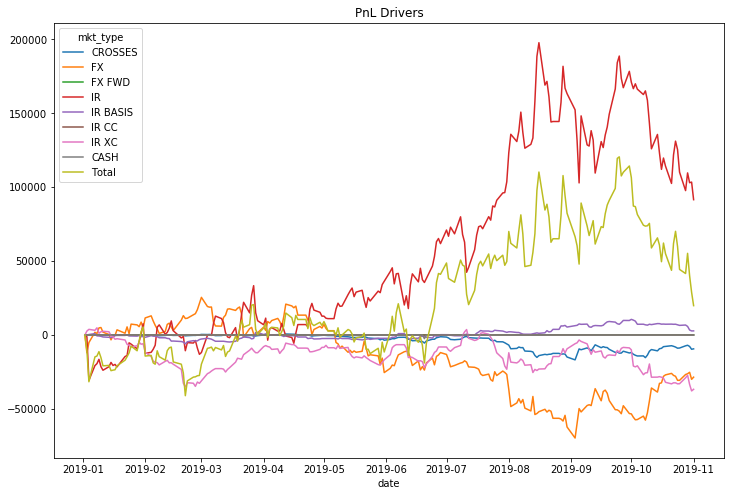

In [146]:
result['Total'] = result.sum(axis=1)
result.plot(figsize=(12, 8), title='PnL Drivers')

As we can see in the chart above, over the backtest period rates drive most of the positive swap performance while cross currency effects are largely a negative drag over the period. FX, although a small positive contributor through mid 2019, ultimately drives much of the negative contribution through the remainder of the year. Remember we are looking at the swap hedge only here so FX will be entirely offset by the bond in the bond+swap package.

In this note we decomposed the fixfix swap but you can use this framework to analyse any trade or portfolio - looking forward to hearing your feedback!

### What's New
* `PnlExplain` which we covered in this note!
* `Portfolio.from_frame` and `Portfolio.from_csv` to help map and represent your portfolio object from a dataframe or csv file.
* `to_frame` to view complex results - see example [here](https://nbviewer.jupyter.org/github/goldmansachs/gs-quant/blob/master/gs_quant/examples/01_pricing_and_risk/00_rates/010014_spread_option_grid_pricing.ipynb)
* Solvers for different fields to allow to solve for a strike or fixed rate such that PV=x. Examples to come - please reach out in the meantime.